In this Jupyter Notebook, we estimate and plot the basin-region-scale level of hydropower deployment in the world's top 20 eco-sensitive river basins for 2015 and 2050 under eight scenarios.

Author: AFM Kamal Chowdhury

Email: kchy@umd.edu

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import geopandas

In [2]:
# path to data directory
datapath = '../data/'

# path to figures directory
figpath = '../figures/'

# set 'yes' to save the output figure
save_outputs = 'no' # 'yes' 'no'

### Exploitable hydropower potential

In [3]:
# import total exploitable hydropower potential data
df_hydro_rsrc = pd.read_csv(datapath+'other_data/L227.SmthRenewRsrcCurves_hydro.csv', skiprows=2, header=0)

# convert hydro exploitable potential from EJ to GWh (1 Exajoules (EJ) = 277777.78 GWh)
df_hydro_rsrc['exploitable_gwh'] = df_hydro_rsrc['maxSubResource'] * 277777.78

# set 'smooth.renewable.subresource' (which is same as 'technology' in gcam_output files) as index
df_hydro_rsrc = df_hydro_rsrc.set_index('smooth.renewable.subresource')

len(df_hydro_rsrc)

214

### Analyze GCAM outputs

Scenarios and years to analyze

In [4]:
# import the csv file with scenario names
df_scs = pd.read_csv(datapath+'gcam_outputs/scenario_names.csv', header=0)


# names of the folders with scenario results
scs = list(df_scs['scenario_folder'])

# short names of the scenarios for plotting/analysis
scs_shortnames = list(df_scs['scenario_shortname'])

# full names of the scenarios for plotting/analysis
scs_fullnames = list(df_scs['scenario_fullname'])

print(len(scs))

8


In [5]:
# select the years for which GCAM outputs to be analyzed
data_columns = ['2015', '2050']

Estimate results for all scenarios

In [6]:
# declare a list to store hydropower results for all scenarios
list_allscs_hydro_vre_by_basin = []

for i in range(len(scs)):
    # for each scenario, import GCAM outputs for electricity generation by technology
    df_elec_gen = pd.read_csv(datapath+'gcam_outputs/scenario_outputs/'+str(scs[i])+'/queryout_elec_gen_by_tech.csv',
                                                                                          skiprows=1, header=0)
        
    """ hydro genetation by periods """
    
    # separate hydropower outputs for desired periods (here, 'technology' represents basin-regions)
    df_hydro_basin_ej = df_elec_gen[(df_elec_gen.subsector=='hydropower')].groupby(['technology'])[data_columns].sum()
    
    # convert units of hydro-electricity generation from EJ/year to GWh/year
    df_hydro_basin_gwh = df_hydro_basin_ej * 277777.78
    
    
    # import eploitable hydropower potentials for each basin-regions
    df_hydro_basin_gwh['exploitable_gwh'] = df_hydro_basin_gwh.index.map(df_hydro_rsrc['exploitable_gwh'].to_dict())
        
        
    # include basin and region names
    df_hydro_basin_gwh['basin'] = df_hydro_basin_gwh.index.map(df_hydro_rsrc['basin_nm'].to_dict())
    df_hydro_basin_gwh['region'] = df_hydro_basin_gwh.index.map(df_hydro_rsrc['region'].to_dict())
    
    
    # add scenario short-names for further analysis
    df_hydro_basin_gwh['Scenario'] = scs_shortnames[i]
    
    # append the hydrpower results for each scenario into the list
    list_allscs_hydro_vre_by_basin.append(df_hydro_basin_gwh)


print (len(list_allscs_hydro_vre_by_basin))

8


Concat results for all scenarios

In [7]:
# concat all hydro share results and reset index
df_allscs_hydro_vre_by_basin = pd.concat([list_allscs_hydro_vre_by_basin[i] for i in range(len(scs))]).reset_index()

# form basin-region names
df_allscs_hydro_vre_by_basin['basin_reg'] = df_allscs_hydro_vre_by_basin.agg('{0[basin]} - {0[region]}'.format, axis=1)

# form region-basin names
df_allscs_hydro_vre_by_basin['reg_basin'] = df_allscs_hydro_vre_by_basin.agg('{0[region]}{0[basin]}'.format, axis=1)

# set region-basin as index to copy results for different scenarios with same index
df_allscs_hydro_vre_by_basin = df_allscs_hydro_vre_by_basin.set_index('reg_basin')

### Hydropower deployment levels in 2015 and 2050

Estimate deployments as share of exploitable potential

In [8]:
# deployment shares in 2015
df_allscs_hydro_vre_by_basin['h_expshare_2015'] = df_allscs_hydro_vre_by_basin['2015'].div(
                                                                    df_allscs_hydro_vre_by_basin['exploitable_gwh'])

# deployment shares in 2050
df_allscs_hydro_vre_by_basin['h_expshare_2050'] = df_allscs_hydro_vre_by_basin['2050'].div(
                                                                    df_allscs_hydro_vre_by_basin['exploitable_gwh'])

In [9]:
# create copies of the hydropower results for each scenario
ref_hydro_vre_by_basin = df_allscs_hydro_vre_by_basin[df_allscs_hydro_vre_by_basin.Scenario=='Ref'].copy()
at_hydro_vre_by_basin = df_allscs_hydro_vre_by_basin[df_allscs_hydro_vre_by_basin.Scenario=='AT'].copy()

hg_hydro_vre_by_basin = df_allscs_hydro_vre_by_basin[df_allscs_hydro_vre_by_basin.Scenario=='HG'].copy()
hgat_hydro_vre_by_basin = df_allscs_hydro_vre_by_basin[df_allscs_hydro_vre_by_basin.Scenario=='HG+AT'].copy()

et_hydro_vre_by_basin = df_allscs_hydro_vre_by_basin[df_allscs_hydro_vre_by_basin.Scenario=='ET'].copy()
etat_hydro_vre_by_basin = df_allscs_hydro_vre_by_basin[df_allscs_hydro_vre_by_basin.Scenario=='ET+AT'].copy()

ethg_hydro_vre_by_basin = df_allscs_hydro_vre_by_basin[df_allscs_hydro_vre_by_basin.Scenario=='ET+HG'].copy()
ethgat_hydro_vre_by_basin = df_allscs_hydro_vre_by_basin[df_allscs_hydro_vre_by_basin.Scenario=='ET+HG+AT'].copy()


# copy deployment shares of alternative scenarios (for 2050) into the df of Ref scenario
ref_hydro_vre_by_basin['h_expshare_2050_hg'] = hg_hydro_vre_by_basin['h_expshare_2050']
ref_hydro_vre_by_basin['h_expshare_2050_et'] = et_hydro_vre_by_basin['h_expshare_2050']
ref_hydro_vre_by_basin['h_expshare_2050_ethg'] = ethg_hydro_vre_by_basin['h_expshare_2050']
ref_hydro_vre_by_basin['h_expshare_2050_at'] = at_hydro_vre_by_basin['h_expshare_2050']
ref_hydro_vre_by_basin['h_expshare_2050_hgat'] = hgat_hydro_vre_by_basin['h_expshare_2050']
ref_hydro_vre_by_basin['h_expshare_2050_etat'] = etat_hydro_vre_by_basin['h_expshare_2050']
ref_hydro_vre_by_basin['h_expshare_2050_ethgat'] = ethgat_hydro_vre_by_basin['h_expshare_2050']

## Basin-region-scale hydropower deployment

Separate data for selected basins

In [10]:
# import csv file that contain basin names with eco-sensitivity ranks
df_basin_eco_sensitivity = pd.read_csv(datapath+'other_data/eco_sensitivity_rank_by_basins.csv', header=0)

# select top 20 eco-sensitive basins
selected_basins1 = list(df_basin_eco_sensitivity[df_basin_eco_sensitivity['basin_eco_sensitivity_rank']<=20]['basin_nm'])

# separate data for the top 20 eco-sensitive basins
var_to_plot = ref_hydro_vre_by_basin[ref_hydro_vre_by_basin.basin.isin(selected_basins1)].round(decimals=2).copy()

# check data
# var_to_plot.head()

Estimate regional shares of exploitable potentials to show on plot

In [11]:
# shorten some region names for visualization purpose
var_to_plot = var_to_plot.replace(regex={'Africa_Eastern': 'Africa E',
 'Africa_Northern': 'Africa N',
 'Africa_Southern': 'Africa S',
 'Africa_Western': 'Africa W',
 'Europe_Non_EU': 'Non EU',
 'European Free Trade Association': 'EFTA',
 'South America_Northern': 'S Am. N',
 'South America_Southern': 'S Am. S',
 'Southeast Asia': 'SE Asia',
 'South Asia': 'S Asia',
 'Ganges_Bramaputra': 'Ganges',
 'Gulf_of_Guinea': 'Gulf_Guinea'})

In [12]:
# estimate and add basin-scale exploitable potentials
var_to_plot['exploitable_gwh_by_basin'] = var_to_plot['basin'].map(
                                                    var_to_plot.groupby('basin')['exploitable_gwh'].sum().to_dict())

# estimate regional shares of exploitable potentials
var_to_plot['exploitable_share_by_reg'] = round(100*var_to_plot['exploitable_gwh'].div(
                                                    var_to_plot['exploitable_gwh_by_basin']),0).astype(int)

# create region names with regional exploitable shares to show on heatmaps
var_to_plot['region2'] = var_to_plot.agg('{0[region]} {0[exploitable_share_by_reg]}%'.format, axis=1)

Import basin shapefile to plot geographical map

In [14]:
# read basin shapefile
df_basin_shp = geopandas.read_file(datapath+'other_data/basin_shapefile/reg_bas_int.shp')

# create columns with reg_basin names as in hydropower results estimated above
df_basin_shp['rg_bs_enh'] = df_basin_shp.agg('hydro_{0[reg_nm]}_{0[basin_nm]}'.format, axis=1)

Define basin groups and include in basin-shapefile

In [15]:
"""
Define basin-groups based on deployment levels by 2050 in major portion of the basins

Group A: High to Extensive deployment across all scenarios

Group B: High to Extensive deployment only under RapidGrowth and/or Transition, even with AT

Group C: Low to Moderate deployment under all demand conditions, at least with AT

"""

# basin grouping of the top 20 eco-sensitive basins
basin_grp = {'Danube':'B', 'Lena':'C', 'Amur':'C', 
            'Yangtze':'A','Xun_Jiang':'A', 'Mekong':'B', 
            'Salween':'C', 'Irrawaddy':'C', 'Ganges_Bramaputra':'B', 'Indus':'A',           
            'Nile':'B', 'Niger':'B', 'Gulf_of_Guinea':'B', 'Congo':'C','Zambezi':'B', 
            'Orinoco':'B','Magdalena':'C', 'Amazon':'B', 'Tocantins':'A','La_Plata':'A'}

# add basin groups (A, B, C) to basin-shapefile
df_basin_shp['basin_grp'] = df_basin_shp['basin_nm'].map(basin_grp)

Import basin-names to label over geographical map

In [16]:
# import csv file with basin names to lable over geographical map
basin_shp_ecohydro_labels = pd.read_csv(
                    datapath+'other_data/basin_shapefile/basin_shp_dataset_with_eco_sensitivity_rank_labels.csv',
                                                                                            skiprows=0, header=0)
# set region-basin names as index
basin_shp_ecohydro_labels_tomap = basin_shp_ecohydro_labels.set_index('rg_bs_enh')

# adjust coordinates of the basin-name labels to show on geographical map
xcor_adj = {'hydro_Africa_Western_Congo': -18.5,
             'hydro_China_Yangtze': -7.5,
             'hydro_Brazil_Amazon': -33.5,
             'hydro_India_Ganges_Bramaputra': -23.9,
             'hydro_Southeast Asia_Mekong': 3.0,
             'hydro_Southeast Asia_Salween': -12.5,
             'hydro_Africa_Eastern_Nile': 8.5,
             'hydro_Pakistan_Indus': -2.5,
             'hydro_Africa_Western_Niger': -13.5,
             'hydro_Southeast Asia_Irrawaddy': -21.0,
             'hydro_Argentina_La_Plata': 11.5,
             'hydro_Colombia_Orinoco': 3.0,
             'hydro_Central Asia_Amur': 8.5,
             'hydro_Africa_Southern_Zambezi': -8.5,
             'hydro_China_Xun_Jiang': 2.5,
             'hydro_Africa_Southern_Gulf_of_Guinea': -27.0,
             'hydro_South America_Northern_Magdalena': -24.5,
             'hydro_EU-12_Danube': -6.5,
             'hydro_Russia_Lena': -2.5,
             'hydro_Brazil_Tocantins': 2.9}



ycor_adj = {'hydro_Africa_Western_Congo': -8.5,
             'hydro_China_Yangtze': 5.5,
             'hydro_Brazil_Amazon': -4.5,
             'hydro_India_Ganges_Bramaputra': -3.9,
             'hydro_Southeast Asia_Mekong': -7.5,
             'hydro_Southeast Asia_Salween': -7.5,
             'hydro_Africa_Eastern_Nile': 0.0,
             'hydro_Pakistan_Indus': 6.0,
             'hydro_Africa_Western_Niger': 6.0,
             'hydro_Southeast Asia_Irrawaddy': -4.9,
             'hydro_Argentina_La_Plata': -3.0,
             'hydro_Colombia_Orinoco': 6.5,
             'hydro_Central Asia_Amur': 0.5,
             'hydro_Africa_Southern_Zambezi': -8.5,
             'hydro_China_Xun_Jiang': -5.5,
             'hydro_Africa_Southern_Gulf_of_Guinea': 4.0,
             'hydro_South America_Northern_Magdalena': -4.5,
             'hydro_EU-12_Danube': -6.9,
             'hydro_Russia_Lena': -0.5,
             'hydro_Brazil_Tocantins': -2.5}


# include basin-name labels with adjusted coordinates
df_basin_shp['basin_shp_ecohydro_labels_tomap'] = df_basin_shp['rg_bs_enh'].map(
                                                        basin_shp_ecohydro_labels_tomap['top20_labels_unique'].to_dict())
df_basin_shp['xcor_adj'] = df_basin_shp['rg_bs_enh'].map(xcor_adj)
df_basin_shp['ycor_adj'] = df_basin_shp['rg_bs_enh'].map(ycor_adj)

# df_basin_shp.head()

Define a function to create heatmaps (colored-squares) to show basin-region-scale deployment levels

In [17]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", va="center",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.45, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.45, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=5)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im

Select plotting sequence (for heatmaps), colors, and labels

In [18]:
# select deployment shares in 2050 for all scenarios and in 2015 in Ref (same in other scenarios)
expshare_cols = ['h_expshare_2015', 'h_expshare_2050','h_expshare_2050_at', 
                 'h_expshare_2050_hg', 'h_expshare_2050_hgat', 'h_expshare_2050_et', 'h_expshare_2050_etat',
                   'h_expshare_2050_ethg', 'h_expshare_2050_ethgat']

# scenario short names as x-axis ticks
x = ['2015','Ref', 'Ref$\\bf{+AT}$', 'HG', 'HG$\\bf{+AT}$',  'ET', 'ET$\\bf{+AT}$',  'ET+HG',  'ET+HG$\\bf{+AT}$']

# scenario full names to update x-axis ticks 
scnames_new = ['2015 (existing)', 'Reference', 'Reference*', 'RapidGrowth',
               'RapidGrowth*','Transition','Transition*','Transition+RapidGrowth','Transition+RapidGrowth*']

# short names for deployment categories
qrates = ['Low', 'Mod', 'High', 'Ext'] 

# slices of deployment shares for the four categories
norm = matplotlib.colors.BoundaryNorm([0,0.20,0.50,0.80,1.00], 4)


# Colors for basin groups
colors =  ['#c8641e80', '#00006463', '#17becf8f']

cmap_cat = (matplotlib.colors.ListedColormap(colors))

# colors for the four deployment levels
colors2 = ['#077e1599', '#f0b400ad', '#ff8362', '#a50505cc']

cmap_cat2 = (matplotlib.colors.ListedColormap(colors2))

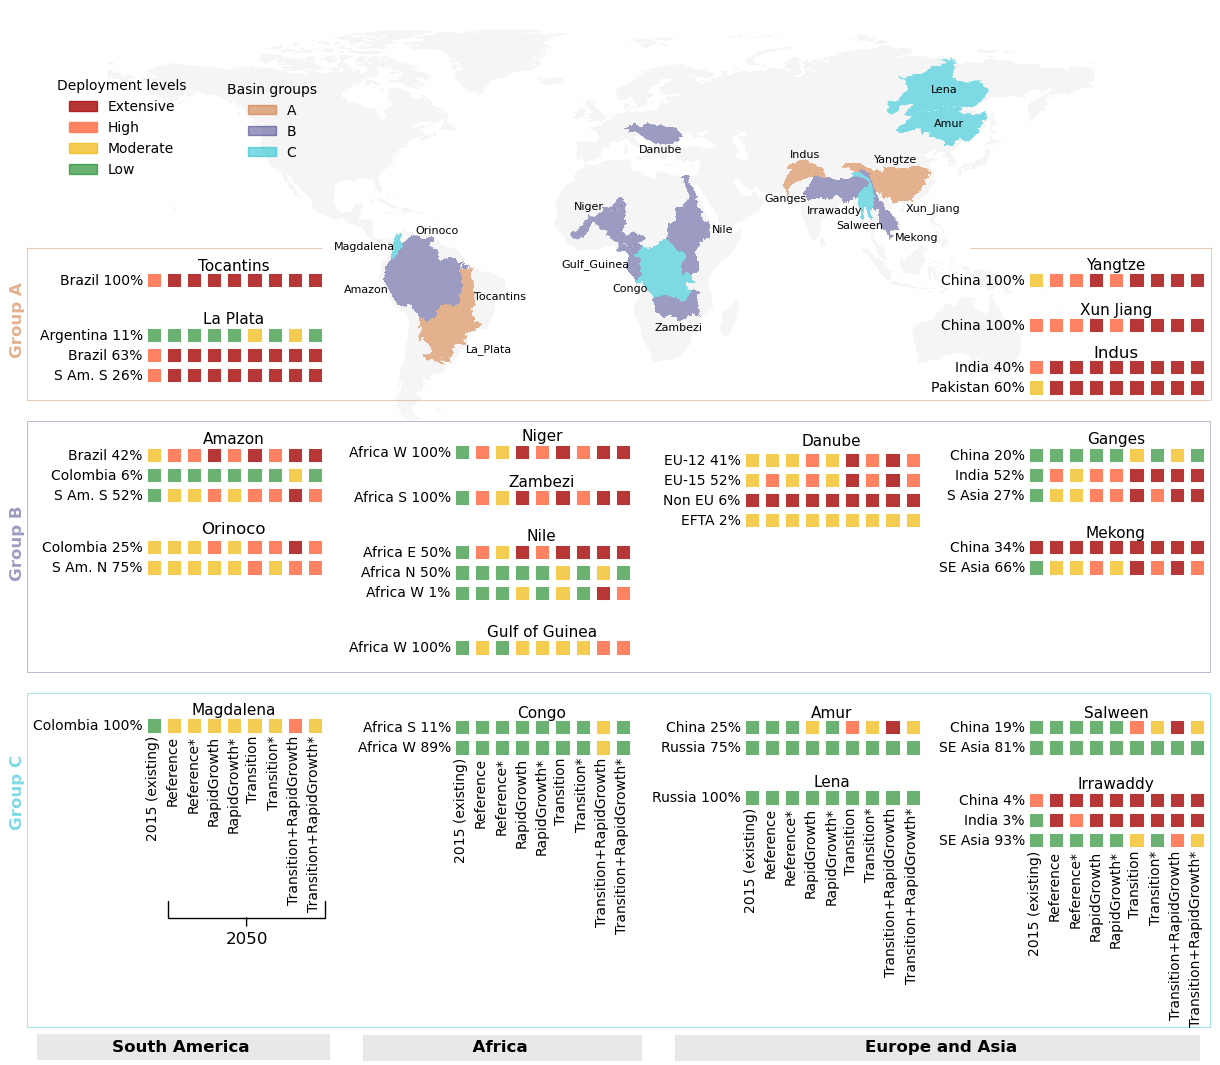

In [19]:
fig, axes = plt.subplot_mosaic(
    [["t1","t1","t1","t1","t1","t1","t1","t1","t1","t1","t1","t1","t1","t1","t1","t1","t1","t1","t1","t1"],
     ["b1", "b2", "b3", "b4", "b5", "b6", "b7", "b8", "b9", "b10", "b11", "b12", "b13", "b14", "b15", "b16", "b17"
     , "b18", "b19", "b20"]], 
    figsize=(14,15), gridspec_kw=dict(height_ratios=[5, 2]))

fig.subplots_adjust(wspace=0.1,hspace=-0.15, top=1, bottom=0.2)


#####################################################
### geographical map showing three basin groups #####
#####################################################

# hide axis 
axes["t1"].set_axis_off();

# plot map
df_basin_shp.plot(column = 'basin_grp', ax=axes["t1"], categorical=True, cmap=cmap_cat, 
                  edgecolor=None, #linewidth=0.01, #'whitesmoke'
                 missing_kwds={"color": "whitesmoke"})


# add names of top 20 eco-sensitive basins as labels over geographical map
for idx, row in df_basin_shp.iterrows():
    if pd.notna(row['basin_shp_ecohydro_labels_tomap']): 
        axes["t1"].annotate(row['basin_shp_ecohydro_labels_tomap'],
                      xy=(row.geometry.centroid.x + row['xcor_adj'], 
                         row.geometry.centroid.y  + row['ycor_adj']),fontsize=8) 




#################################################################################
### heatmaps (colored-squares) showing basin-region-scale deployment levels #####
#################################################################################

# set size and position of the colored squares (i.e., heatmaps)
hmap_width = 0.13

# set positions of the subplots according to continent and basin-groups
axes["b3"].set_position([0.185, 0.605, hmap_width, 0.1]) ## Tocantins
axes["b2"].set_position([0.185, 0.555, hmap_width, 0.1]) ## La_Plata


axes["b1"].set_position([0.185, 0.475, hmap_width, 0.1]) ##Amazon
axes["b4"].set_position([0.185, 0.420, hmap_width, 0.1]) ## Orinoco

axes["b5"].set_position([0.185, 0.308, hmap_width, 0.1]) ## Megdalena


axes["b6"].set_position([0.405, 0.4905, hmap_width, 0.1]) ## Niger
axes["b7"].set_position([0.405, 0.46, hmap_width, 0.1]) ## Zambezi
axes["b8"].set_position([0.405, 0.41, hmap_width, 0.1]) ## Nile
axes["b9"].set_position([0.405, 0.36, hmap_width, 0.1]) ## Gulf_of_Gunea

axes["b10"].set_position([0.405, 0.30, hmap_width, 0.1]) ## Congo


axes["b11"].set_position([0.815, 0.605, hmap_width, 0.1]) ##Yangtze
axes["b12"].set_position([0.815, 0.575, hmap_width, 0.1]) ## Xun_jiang
axes["b13"].set_position([0.815, 0.54, hmap_width, 0.1]) ## Indus

axes["b14"].set_position([0.815, 0.475, hmap_width, 0.1]) ## Ganges
axes["b15"].set_position([0.815, 0.420, hmap_width, 0.1]) ## Mekong


axes["b16"].set_position([0.815, 0.30, hmap_width, 0.1]) ## Salween
axes["b17"].set_position([0.815, 0.245, hmap_width, 0.1]) ## Irrawaddy


axes["b18"].set_position([0.612, 0.465, hmap_width, 0.1]) ##Danube

axes["b19"].set_position([0.612, 0.30, hmap_width, 0.1]) ##Amur
axes["b20"].set_position([0.612, 0.26, hmap_width, 0.1]) ##Lena




####### =============== South America ==============########

#### Amazon

data1 = var_to_plot[var_to_plot.basin=='Amazon'][expshare_cols].values
y1 = var_to_plot[var_to_plot.basin=='Amazon']['region2']

im1 = heatmap(data1, y1, x, ax=axes["b1"], cmap=cmap_cat2, norm=norm)

axes["b1"].set_xticks([])

axes["b1"].text(0.5, 1.2, "Amazon", size=11, rotation=0., ha="center", va="top", #weight='bold',
                transform=axes["b1"].transAxes)



#### La_Plata
data2 = var_to_plot[var_to_plot.basin=='La_Plata'][expshare_cols].values
y2 = var_to_plot[var_to_plot.basin=='La_Plata']['region2']

im2 = heatmap(data2, y2, x, ax=axes["b2"], cmap=cmap_cat2, norm=norm)

axes["b2"].text(0.5, 1.2, "La Plata", size=11, rotation=0., ha="center", va="top", #weight='bold',
                transform=axes["b2"].transAxes)

axes["b2"].set_xticks([])



#### Tocantins
data3 = var_to_plot[var_to_plot.basin=='Tocantins'][expshare_cols].values
y3 = var_to_plot[var_to_plot.basin=='Tocantins']['region2']

im3 = heatmap(data3, y3, x, ax=axes["b3"], cmap=cmap_cat2, norm=norm)

axes["b3"].text(0.5, 1.5, "Tocantins", size=11, rotation=0., ha="center", va="top", #weight='bold',
                transform=axes["b3"].transAxes)

axes["b3"].set_xticks([])


#### Orinoco
data4 = var_to_plot[var_to_plot.basin=='Orinoco'][expshare_cols].values
y4 = var_to_plot[var_to_plot.basin=='Orinoco']['region2']

im4 = heatmap(data4, y4, x, ax=axes["b4"], cmap=cmap_cat2, norm=norm)

axes["b4"].text(0.5, 1.35, "Orinoco", size=12, rotation=0., ha="center", va="top", #weight='bold',
                transform=axes["b4"].transAxes)
axes["b4"].set_xticks([])


#### Magdalena
data5 = var_to_plot[var_to_plot.basin=='Magdalena'][expshare_cols].values
y5 = var_to_plot[var_to_plot.basin=='Magdalena']['region2']

im5 = heatmap(data5, y5, x, ax=axes["b5"], cmap=cmap_cat2, norm=norm)

axes["b5"].text(0.5, 1.55, "Magdalena", size=11, rotation=0., ha="center", va="top", #weight='bold',
                transform=axes["b5"].transAxes)



######## =============== Africa ==============########

#### Niger
data6 = var_to_plot[var_to_plot.basin=='Niger'][expshare_cols].values
y6 = var_to_plot[var_to_plot.basin=='Niger']['region2']

im6 = heatmap(data6, y6, x, ax=axes["b6"], cmap=cmap_cat2, norm=norm)

axes["b6"].text(0.5, 1.55, "Niger", size=11, rotation=0., ha="center", va="top", #weight='bold',
                transform=axes["b6"].transAxes)

axes["b6"].set_xticks([])



#### Zambezi
data7 = var_to_plot[var_to_plot.basin=='Zambezi'][expshare_cols].values
y7 = var_to_plot[var_to_plot.basin=='Zambezi']['region2']

im7 = heatmap(data7, y7, x, ax=axes["b7"], cmap=cmap_cat2, norm=norm)

axes["b7"].text(0.5, 1.55, "Zambezi", size=11, rotation=0., ha="center", va="top", #weight='bold',
                transform=axes["b7"].transAxes)

axes["b7"].set_xticks([])



#### Nile
data8 = var_to_plot[var_to_plot.basin=='Nile'][expshare_cols].values
y8 = var_to_plot[var_to_plot.basin=='Nile']['region2']

im8 = heatmap(data8, y8, x, ax=axes["b8"], cmap=cmap_cat2, norm=norm)

axes["b8"].text(0.5, 1.2, "Nile", size=11, rotation=0., ha="center", va="top", #weight='bold',
                transform=axes["b8"].transAxes)

axes["b8"].set_xticks([])



#### Gulf_Guinea
data9 = var_to_plot[var_to_plot.basin=='Gulf_Guinea'][expshare_cols].values
y9 = var_to_plot[var_to_plot.basin=='Gulf_Guinea']['region2']

im9 = heatmap(data9, y9, x, ax=axes["b9"], cmap=cmap_cat2, norm=norm)

axes["b9"].text(0.5, 1.55, "Gulf of Guinea", size=11, rotation=0., ha="center", va="top", #weight='bold',
                transform=axes["b9"].transAxes)

axes["b9"].set_xticks([])



### Congo
data10 = var_to_plot[var_to_plot.basin=='Congo'][expshare_cols].values
y10 = var_to_plot[var_to_plot.basin=='Congo']['region2']

im10 = heatmap(data10, y10, x, ax=axes["b10"], cmap=cmap_cat2, norm=norm)

axes["b10"].text(0.5, 1.25, "Congo", size=11, rotation=0., ha="center", va="top", #weight='bold',
                transform=axes["b10"].transAxes)



########============ Asia ===============#########

### Yangtze
data11 = var_to_plot[var_to_plot.basin=='Yangtze'][expshare_cols].values
y11 = var_to_plot[var_to_plot.basin=='Yangtze']['region2']

im11 = heatmap(data11, y11, x, ax=axes["b11"], cmap=cmap_cat2, norm=norm)

axes["b11"].text(0.5, 1.55, "Yangtze", size=11, rotation=0., ha="center", va="top", #weight='bold',
                transform=axes["b11"].transAxes)

axes["b11"].set_xticks([])


### Xun_Jiang
data12 = var_to_plot[var_to_plot.basin=='Xun_Jiang'][expshare_cols].values
y12 = var_to_plot[var_to_plot.basin=='Xun_Jiang']['region2']

im12 = heatmap(data12, y12, x, ax=axes["b12"], cmap=cmap_cat2, norm=norm)

axes["b12"].text(0.5, 1.55, "Xun Jiang", size=11, rotation=0., ha="center", va="top", #weight='bold',
                transform=axes["b12"].transAxes)

axes["b12"].set_xticks([])


### Indus
data13 = var_to_plot[var_to_plot.basin=='Indus'][expshare_cols].values
y13 = var_to_plot[var_to_plot.basin=='Indus']['region2']

im13 = heatmap(data13, y13, x, ax=axes["b13"], cmap=cmap_cat2, norm=norm)

axes["b13"].text(0.5, 1.25, "Indus", size=12, rotation=0., ha="center", va="top", #weight='bold',
                transform=axes["b13"].transAxes)

axes["b13"].set_xticks([])



### Ganges
data14 = var_to_plot[var_to_plot.basin=='Ganges'][expshare_cols].values
y14 = var_to_plot[var_to_plot.basin=='Ganges']['region2']

im14 = heatmap(data14, y14, x, ax=axes["b14"], cmap=cmap_cat2, norm=norm)

axes["b14"].text(0.5, 1.2, "Ganges", size=11, rotation=0., ha="center", va="top", #weight='bold',
                transform=axes["b14"].transAxes)

axes["b14"].set_xticks([])



### Mekong
data15 = var_to_plot[var_to_plot.basin=='Mekong'][expshare_cols].values
y15 = var_to_plot[var_to_plot.basin=='Mekong']['region2']

im15 = heatmap(data15, y15, x, ax=axes["b15"], cmap=cmap_cat2, norm=norm)

axes["b15"].text(0.5, 1.25, "Mekong", size=11, rotation=0., ha="center", va="top", #weight='bold',
                transform=axes["b15"].transAxes)

axes["b15"].set_xticks([])



### Salween
data16 = var_to_plot[var_to_plot.basin=='Salween'][expshare_cols].values
y16 = var_to_plot[var_to_plot.basin=='Salween']['region2']

im16 = heatmap(data16, y16, x, ax=axes["b16"], cmap=cmap_cat2, norm=norm)

axes["b16"].text(0.5, 1.25, "Salween", size=11, rotation=0., ha="center", va="top", #weight='bold',
                transform=axes["b16"].transAxes)

axes["b16"].set_xticks([])


### Irrawaddy
data17 = var_to_plot[var_to_plot.basin=='Irrawaddy'][expshare_cols].values
y17 = var_to_plot[var_to_plot.basin=='Irrawaddy']['region2']

im17 = heatmap(data17, y17, x, ax=axes["b17"], cmap=cmap_cat2, norm=norm)

axes["b17"].text(0.5, 1.2, "Irrawaddy", size=11, rotation=0., ha="center", va="top", #weight='bold',
                transform=axes["b17"].transAxes)



####### =========== Europe-Russia ========= #######

### Danube
data18 = var_to_plot[var_to_plot.basin=='Danube'][expshare_cols].values
y18 = var_to_plot[var_to_plot.basin=='Danube']['region2']

im18 = heatmap(data18, y18, x, ax=axes["b18"], cmap=cmap_cat2, norm=norm)

axes["b18"].text(0.5, 1.19, "Danube", size=11, rotation=0., ha="center", va="top", #weight='bold',
                transform=axes["b18"].transAxes)

axes["b18"].set_xticks([])


### Amur
data19 = var_to_plot[var_to_plot.basin=='Amur'][expshare_cols].values
y19 = var_to_plot[var_to_plot.basin=='Amur']['region2']

im19 = heatmap(data19, y19, x, ax=axes["b19"], cmap=cmap_cat2, norm=norm)

axes["b19"].text(0.5, 1.25, "Amur", size=11, rotation=0., ha="center", va="top", #weight='bold',
                transform=axes["b19"].transAxes)

axes["b19"].set_xticks([])



### Lena
data20 = var_to_plot[var_to_plot.basin=='Lena'][expshare_cols].values
y20 = var_to_plot[var_to_plot.basin=='Lena']['region2']

im20 = heatmap(data20, y20, x, ax=axes["b20"], cmap=cmap_cat2, norm=norm)

axes["b20"].text(0.5, 1.55, "Lena", size=11, rotation=0., ha="center", va="top", #weight='bold',
                transform=axes["b20"].transAxes)


## Remove outer ticks from the heatmaps
axes["b1"].tick_params(direction='in', length=0, pad=0.01)
axes["b2"].tick_params(direction='in', length=0, pad=0.01)
axes["b3"].tick_params(direction='in', length=0, pad=0.01)
axes["b4"].tick_params(direction='in', length=0, pad=0.01)
axes["b5"].tick_params(direction='in', length=0, pad=0.01)
axes["b6"].tick_params(direction='in', length=0, pad=0.01)
axes["b7"].tick_params(direction='in', length=0, pad=0.01)
axes["b8"].tick_params(direction='in', length=0, pad=0.01)
axes["b9"].tick_params(direction='in', length=0, pad=0.01)
axes["b10"].tick_params(direction='in', length=0, pad=0.01)
axes["b11"].tick_params(direction='in', length=0, pad=0.01)
axes["b12"].tick_params(direction='in', length=0, pad=0.01)
axes["b13"].tick_params(direction='in', length=0, pad=0.01)
axes["b14"].tick_params(direction='in', length=0, pad=0.01)
axes["b15"].tick_params(direction='in', length=0, pad=0.01)
axes["b16"].tick_params(direction='in', length=0, pad=0.01)
axes["b17"].tick_params(direction='in', length=0, pad=0.01)
axes["b18"].tick_params(direction='in', length=0, pad=0.01)
axes["b19"].tick_params(direction='in', length=0, pad=0.01)
axes["b20"].tick_params(direction='in', length=0, pad=0.01)


# Boxes around grouped heatmaps
# Group B
r1 = matplotlib.patches.Rectangle(xy=(-0.635,-2.3), width=6.5, height=6.1, transform=axes["b4"].transAxes,
                                 fc='none', ec=colors[1], lw=0.5)

# Group C
r2 = matplotlib.patches.Rectangle(xy=(-0.635,-13.8), width=6.5, height=15.8, transform=axes["b5"].transAxes,
                                 fc='none', ec=colors[2], lw=0.5)


# Group A -- Left side
r3 = matplotlib.patches.Rectangle(xy=(-0.635,-5.2), width=6.5, height=0.0, transform=axes["b3"].transAxes,
                                 fc='none', ec=colors[0], lw=0.5)

r4 = matplotlib.patches.Rectangle(xy=(-0.635,2.0), width=1.62, height=0.0, transform=axes["b3"].transAxes,
                                 fc='none', ec=colors[0], lw=0.5)

r5 = matplotlib.patches.Rectangle(xy=(-0.635,-5.2), width=0.0, height=7.225, transform=axes["b3"].transAxes,
                                 fc='none', ec=colors[0], lw=0.5)


# Gruop A - Right side
r6 = matplotlib.patches.Rectangle(xy=(-0.3,2.0), width=1.32, height=0.0, transform=axes["b11"].transAxes,
                                 fc='none', ec=colors[0], lw=0.5)

r7 = matplotlib.patches.Rectangle(xy=(1.02,-5.2), width=0.0, height=7.225, transform=axes["b11"].transAxes,
                                 fc='none', ec=colors[0], lw=0.5)

fig.add_artist(r1)
fig.add_artist(r2)
fig.add_artist(r3)
fig.add_artist(r4)
fig.add_artist(r5)
fig.add_artist(r6)
fig.add_artist(r7)

# Texts for Group names
axes["b3"].text(-0.73, 0.4, "Group A", 
                size=12, rotation=90., ha="left", va="top", weight='bold', color=colors[0],
                transform=axes["b3"].transAxes)#, bbox=dict(facecolor='lightgrey', alpha=0.5))

axes["b1"].text(-0.73, 0.0, "Group B", 
                size=12, rotation=90., ha="left", va="top", weight='bold', color=colors[1],
                transform=axes["b1"].transAxes)#, bbox=dict(facecolor='lightgrey', alpha=0.5)) #

axes["b5"].text(-0.73, -0.9, "Group C", 
                size=12, rotation=90., ha="left", va="top", weight='bold', color=colors[2],
                transform=axes["b5"].transAxes)#, bbox=dict(facecolor='lightgrey', alpha=0.5)) #



# Continent names
axes["b5"].text(-0.55, -14.4, "            South America             ", 
                size=12, rotation=0., ha="left", va="top", weight='bold',
                transform=axes["b5"].transAxes, bbox=dict(facecolor='lightgrey', ec='lightgrey', lw=0.01, alpha=0.5))

axes["b10"].text(-0.45, -6.85, "                  Africa                   ", 
                size=12, rotation=0., ha="left", va="top", weight='bold',
                transform=axes["b10"].transAxes, bbox=dict(facecolor='lightgrey', ec='lightgrey', lw=0.01, alpha=0.5))

axes["b19"].text(-0.33, -6.85, "                                Europe and Asia                               ", 
                size=12, rotation=0., ha="left", va="top", weight='bold',
                transform=axes["b19"].transAxes, bbox=dict(facecolor='lightgrey', ec='lightgrey', lw=0.01, alpha=0.5))



axes["b5"].annotate('2050', xy=(0.57, -8.50), xytext=(0.57, -10.00), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=4.7, lengthB=1.0', lw=1.0))


# Legends for basin-groups
patch1 = matplotlib.patches.Patch(color=cmap_cat(0.1), label='A')
patch2 = matplotlib.patches.Patch(color=cmap_cat(0.5), label='B')
patch3 = matplotlib.patches.Patch(color=cmap_cat(0.9), label='C')

axes["t1"].legend(handles=[patch1, patch2, patch3], 
           loc=(0.15,0.64), ncol=1, title="Basin groups", frameon=False)


# Legends for deployment levels
patch11 = matplotlib.patches.Patch(color=cmap_cat2(0.0), label='Low')
patch12 = matplotlib.patches.Patch(color=cmap_cat2(0.3), label='Moderate')
patch13 = matplotlib.patches.Patch(color=cmap_cat2(0.6), label='High')
patch14 = matplotlib.patches.Patch(color=cmap_cat2(0.9), label='Extensive')

axes["b3"].legend(handles=[patch14, patch13, patch12, patch11], 
           loc=(-0.5,5.1), ncol=1, title="Deployment levels", frameon=False)


# update x-ticklabels with scenario full names
axes["b5"].set_xticklabels(scnames_new)
axes["b10"].set_xticklabels(scnames_new)
axes["b17"].set_xticklabels(scnames_new)
axes["b20"].set_xticklabels(scnames_new)


# save output figure
if save_outputs == 'yes':
    plt.savefig(figpath+"figures/fig3_basin_region_scale_hydropower_deployment.pdf", bbox_inches='tight')


plt.show()